In [75]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [76]:
columns = [
    'checking_account', 'duration', 'credit_history', 'purpose', 'credit_amount',
    'savings_account', 'employment', 'installment_rate', 'personal_status_sex',
    'other_debtors', 'residence_since', 'property', 'age', 'other_installment_plans',
    'housing', 'existing_credits', 'job', 'dependents', 'telephone', 'foreign_worker', 'class'
]

df = pd.read_csv('../dataset/german.txt', sep=' ', header=None, names=columns)

df['class'] = df['class'].map({1: 0, 2: 1})

categorical_columns = [
    'checking_account', 'credit_history', 'purpose', 'savings_account',
    'employment', 'personal_status_sex', 'other_debtors', 'property',
    'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker'
]

numerical_columns = [
    'duration', 'credit_amount', 'installment_rate', 'residence_since',
    'age', 'existing_credits', 'dependents'
]

In [77]:
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [78]:
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

dropped:


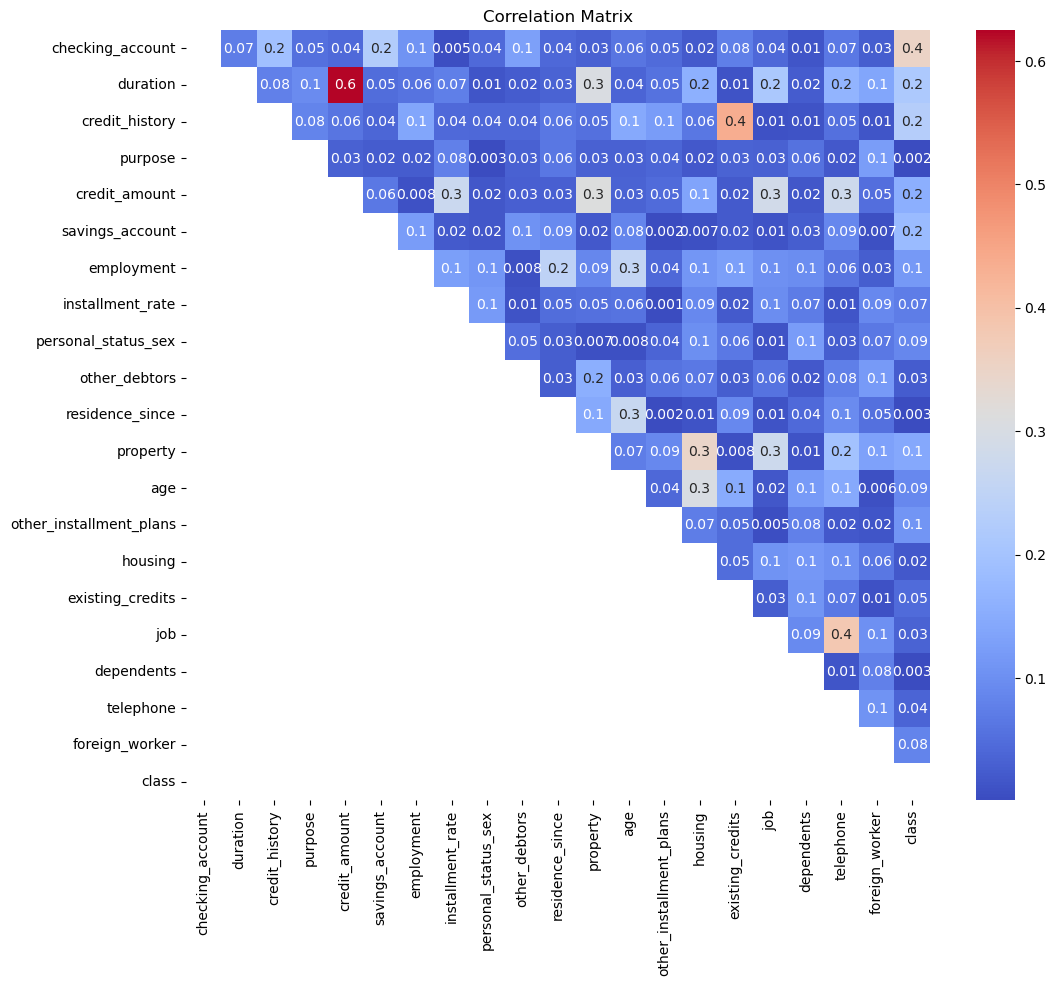

In [79]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print("dropped:")
for column in to_drop:
    print(column)
# Drop highly correlated features
df = df.drop(to_drop, axis=1)
plt.figure(figsize=(12, 10))
sb.heatmap(upper, annot=True, cmap='coolwarm', fmt=".1g")
plt.title('Correlation Matrix')
plt.show()

In [80]:
y = df['class']
df = df.drop('class', axis=1)
x = df.values

In [81]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [90]:
class MLP:
    def __init__(self, hidden_sizes=(50, 30, 10), learning_rate=0.01, epochs=1000, random_state=42):
        self.hidden_sizes = hidden_sizes
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.weights = []
        self.biases = []
        self.train_loss_history = []
        self.test_loss_history = []
    
    def initializeWeights(self, input_size, output_size):
        np.random.seed(self.random_state)
        layer_sizes = [input_size] + list(self.hidden_sizes) + [output_size]
        for i in range(len(layer_sizes) - 1):
            limit = np.sqrt(6 / (layer_sizes[i] + layer_sizes[i + 1]))
            W = np.random.uniform(-limit, limit, (layer_sizes[i], layer_sizes[i + 1]))
            b = np.zeros(layer_sizes[i + 1])
            self.weights.append(W)
            self.biases.append(b)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoidDerivative(self, x):
        return x * (1 - x)
    
    def forward(self, X):
        activations = [X]
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            a = self.sigmoid(z)
            activations.append(a)
        return activations
    
    def computeLoss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    def fit(self, X_train, y_train, X_test, y_test):
        n_samples, n_features = X_train.shape
        self.initializeWeights(n_features, 1)
        y_train = y_train.values.reshape(-1, 1)
        y_test = y_test.values.reshape(-1, 1)
        
        for epoch in range(self.epochs):
            activations = self.forward(X_train)
            y_pred_train = activations[-1]
            
            train_loss = self.computeLoss(y_train, y_pred_train)
            self.train_loss_history.append(train_loss)
            
            test_activations = self.forward(X_test)
            y_pred_test = test_activations[-1]
            test_loss = self.computeLoss(y_test, y_pred_test)
            self.test_loss_history.append(test_loss)
            
            # Back propogation
            error = y_pred_train - y_train
            deltas = [error * self.sigmoidDerivative(y_pred_train)]
            
            for i in reversed(range(len(self.weights) - 1)):
                error = np.dot(deltas[0], self.weights[i + 1].T)
                deltas.insert(0, error * self.sigmoidDerivative(activations[i + 1]))
            
            for i in range(len(self.weights)):
                grad_W = np.dot(activations[i].T, deltas[i]) / n_samples
                self.weights[i] -= self.learning_rate * grad_W
                self.biases[i] -= self.learning_rate * np.mean(deltas[i], axis=0)
            
            # if epoch % 100 == 0:
            #     print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    def predict(self, X):
        activations = self.forward(X)
        return (activations[-1] > 0.5)

LR = 0.1
Train Accuracy: 0.7638
Test Accuracy: 0.7550


Confusion Matrix:
[[129  12]
 [ 37  22]]
LR = 0.01
Train Accuracy: 0.6987
Test Accuracy: 0.7050


Confusion Matrix:
[[141   0]
 [ 59   0]]
LR = 0.001
Train Accuracy: 0.6987
Test Accuracy: 0.7050


Confusion Matrix:
[[141   0]
 [ 59   0]]
LR = 0.0001
Train Accuracy: 0.3013
Test Accuracy: 0.2950


Confusion Matrix:
[[  0 141]
 [  0  59]]


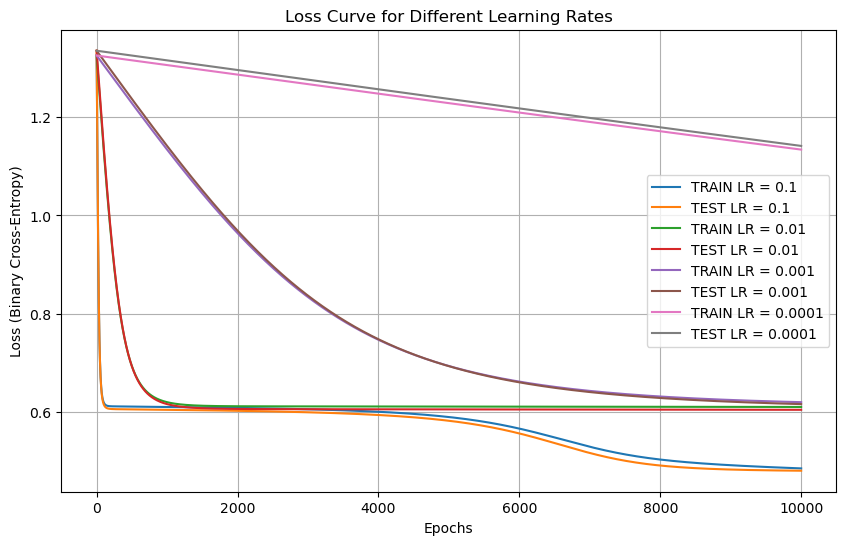

In [94]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
plt.figure(figsize=(10, 6))

for lr in learning_rates:
    mlp = MLP(learning_rate=lr, epochs=10000)
    mlp.fit(x_train, y_train, x_test, y_test)

    # Оценка качества
    y_train_pred = mlp.predict(x_train)
    y_test_pred = mlp.predict(x_test)
    plt.plot(mlp.train_loss_history, label=f"TRAIN LR = {lr}")
    plt.plot(mlp.test_loss_history, label=f"TEST LR = {lr}")
    print(f"LR = {lr}")
    print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}\n")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    # print("\nClassification Report:")
    # print(classification_report(y_test, y_test_pred))

plt.xlabel("Epochs")
plt.ylabel("Loss (Binary Cross-Entropy)")
plt.title("Loss Curve for Different Learning Rates")
plt.legend()
plt.grid(True)
plt.show()